In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
from torchvision import transforms
from PIL import Image

from hdecoder.BaseModel import BaseModel
from hdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt
from datasets.utils.vcoco_utils import get_random_images, walk_through_dir
from utils.visualizer import draw_hoi_results, draw_obj_attentions, draw_hoi_attention

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  2.0 ; cuda:  cu117
detectron2: 0.6
/home/djjin/Mygit/X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
from utils.arguments import load_vcoco_opt_command, load_vcoco_parser

cmdline_args = load_vcoco_parser()
# cmdline_args.conf_files = [os.path.join(home_dir, "configs/hdecoder/vcoco_large.yaml")]
# model_path = '../backup/data/output/XDecoder_HOI_230814/Large_90E_0.5904mAP/00234900/default/raw_model_states.pt'

cmdline_args.conf_files = [os.path.join(home_dir, "configs/hdecoder/vcoco.yaml")]
# model_path = '../backup/data/output/XDecoder_HOI_230817/Small_90E_0.4857mAP/00232200/default/raw_model_states.pt'
# model_path = '../backup/data/output/XDecoder_HOI_230817/Small_90E_0.5079mAP/00216000_best/default/raw_model_states.pt'
model_path = '../data/output/test/00216000_best/default/raw_model_states.pt'

cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', model_path] 

opt = load_vcoco_opt_command(cmdline_args)
opt = init_distributed(opt)

In [3]:
pretrained_pth = os.path.join(opt['RESUME_FROM'])

In [4]:
model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()

INFO:utils.model:Loaded backbone.layers.0.blocks.0.dw1.bias, Model Shape: torch.Size([96]) <-> Ckpt Shape: torch.Size([96])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.dw1.weight, Model Shape: torch.Size([96, 1, 3, 3]) <-> Ckpt Shape: torch.Size([96, 1, 3, 3])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.dw2.bias, Model Shape: torch.Size([96]) <-> Ckpt Shape: torch.Size([96])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.dw2.weight, Model Shape: torch.Size([96, 1, 3, 3]) <-> Ckpt Shape: torch.Size([96, 1, 3, 3])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.gamma_1, Model Shape: torch.Size([96]) <-> Ckpt Shape: torch.Size([96])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.gamma_2, Model Shape: torch.Size([96]) <-> Ckpt Shape: torch.Size([96])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.mlp.fc1.bias, Model Shape: torch.Size([384]) <-> Ckpt Shape: torch.Size([384])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.mlp.fc1.weight, Model Shape: torch.Si

In [5]:
t = []
t.append(transforms.Resize(800, interpolation=Image.BICUBIC))
transform = transforms.Compose(t)

In [6]:
print(home_dir)
img_root = home_dir + '/datasets/v-coco/images/val2014'
# walk_through_dir(img_root)

/home/djjin/Mygit/X-Decoder


In [7]:
# image_paths = get_random_images(img_root, nums=10, seed=None)
image_paths = []
image_paths += [home_dir + '/images/custom_img.jpg']
image_paths

['/home/djjin/Mygit/X-Decoder/images/custom_img.jpg']

Detect 3 HOI!!
<person, smile> (72%)
<person, smile> (87%)
<person, smile> (87%)


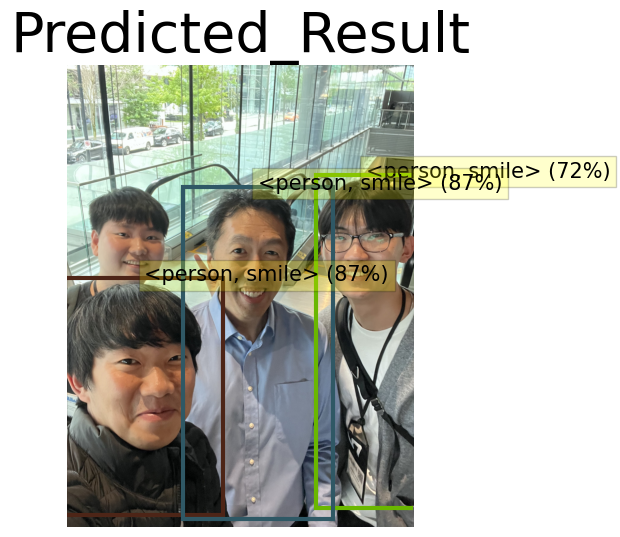

In [8]:
results = []
org_images = []
for image_pth in image_paths:
    image_ori = Image.open(image_pth).convert('RGB')
    
    width = image_ori.size[0]
    height = image_ori.size[1]
    orig_size = (height, width)
    result = model.model.hoi_inference(image_ori, orig_size, transform, thr=0.1)
    results.append(result[-1])
    org_images.append(image_ori)

draw_hoi_results(org_images, results, is_save=False)

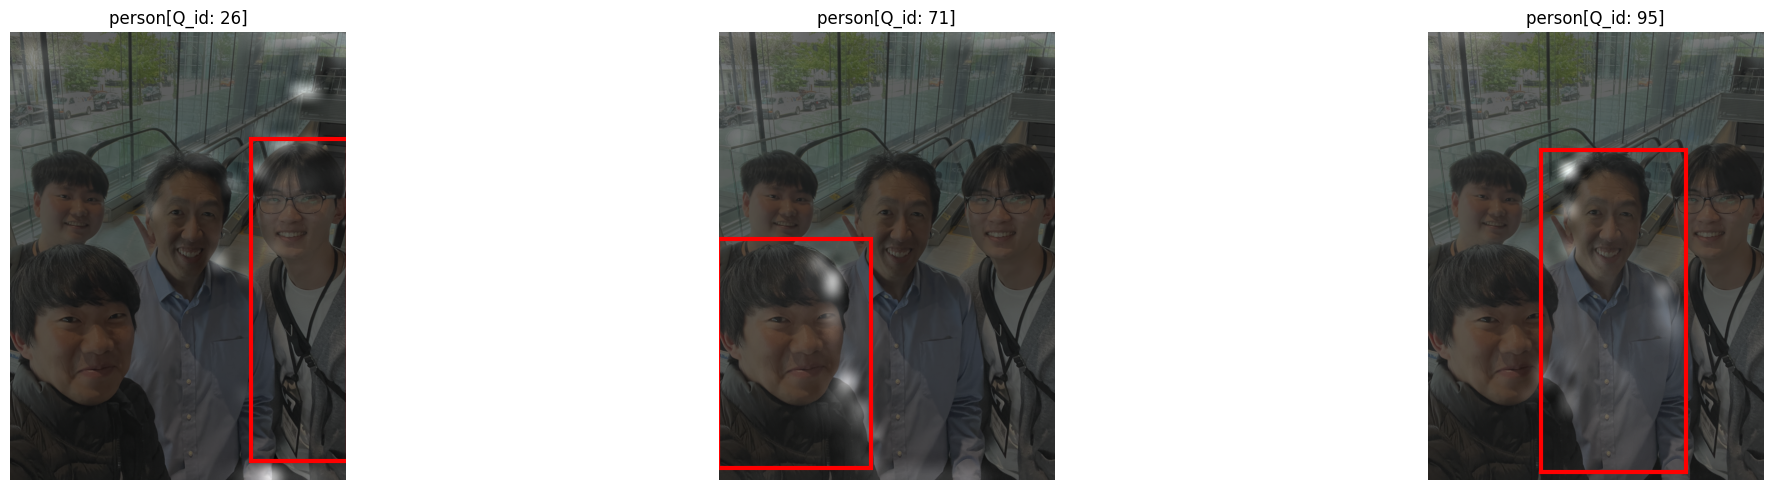

In [9]:
encoder_self_attn = model.model.hoid_head.encoder.transformer.encoder.layers[-1].self_attn
decoder_multihead_attn = model.model.hoid_head.hoi_decoder.hopd_decoder.layers[-1].multihead_attn

results = []
org_images = []
for image_pth in image_paths:
    image_ori = Image.open(image_pth).convert('RGB')
    
    width = image_ori.size[0]
    height = image_ori.size[1]
    orig_size = (height, width)
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []
    
    hooks = [
        model.model.backbone.register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        encoder_self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        ),
        decoder_multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    result = model.model.hoi_inference(image_ori, orig_size, transform, thr=0.5, return_only_outputs=True)
    
    for hook in hooks:
        hook.remove()

    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]

    tensor_orig_size = torch.tensor([width, height, width, height], dtype=torch.float32).to(opt["device"])
    # print(result.keys())
    draw_obj_attentions(result, image_ori, tensor_orig_size, conv_features, dec_attn_weights, thr=0.7, cmap='gist_gray')

Detect 3 HOI!!
<person, smile> (72%)
<person, smile> (87%)
<person, smile> (87%)


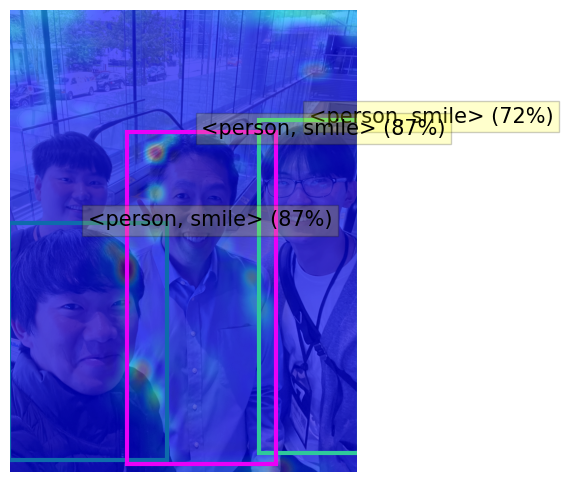

In [10]:

results = []
org_images = []
for image_pth in image_paths:
    image_ori = Image.open(image_pth).convert('RGB')
    
    width = image_ori.size[0]
    height = image_ori.size[1]
    orig_size = (height, width)
    
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []
    
    hooks = [
        model.model.backbone.register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        encoder_self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        ),
        decoder_multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    result = model.model.hoi_inference(image_ori, orig_size, transform, thr=0.5)
    
    for hook in hooks:
        hook.remove()


    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]
    draw_hoi_attention(result, image_ori, conv_features, dec_attn_weights, cmap='jet', alpha=0.3)